# Primer parcial de Inteligencia Artificial Aplicada

## Alumno: Wildo Castro

Fitting 3 folds for each of 5 candidates, totalling 15 fits


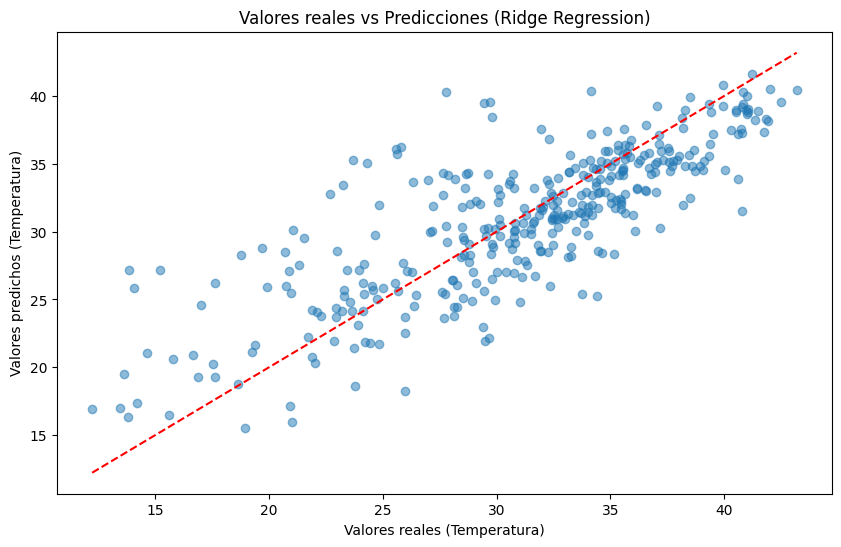

Mejores hiperparámetros: {'alpha': 0.01}
MSE en validación: 15.28391594003941
RMSE en validación: 3.909464917356263
R² en validación: 0.632669228569372


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Función para determinar la estación del año
def determinar_estacion(fecha):
    mes = fecha.month
    if mes in [12, 1, 2]:
        return 'verano'
    elif mes in [3, 4, 5]:
        return 'otoño'
    elif mes in [6, 7, 8]:
        return 'invierno'
    else:
        return 'primavera'

# Paso 1: Cargar y preparar los datos
data = pd.read_csv("Temp_Asu20092021.csv")

# Preprocesamiento de los datos
data.drop(columns=['Unnamed: 0'], inplace=True)
data['Fecha'] = pd.to_datetime(data['Fecha'])
data.set_index('Fecha', inplace=True)

# Resamplear a frecuencia diaria y calcular métricas
daily_data = data.resample('D').agg({'Temperatura': ['max', 'min', 'mean'], 'Humedad': 'mean'})  # Cambiamos max por mean en 'Humedad'
daily_data.columns = ['max_temp', 'min_temp', 'mean_temp', 'mean_humidity']

# Agregar percentiles y temperaturas del año anterior
daily_data['percentile_95_temp'] = data['Temperatura'].resample('D').apply(lambda x: np.percentile(x, 95))
daily_data['temp_prev_year'] = daily_data['mean_temp'].shift(365)  # Temperatura del mismo día del año anterior

# Agregar columna de estación del año
daily_data['estacion'] = daily_data.index.to_series().apply(determinar_estacion)

# Agregar la media de la humedad del día anterior
daily_data['mean_humidity_prev_day'] = daily_data['mean_humidity'].shift(1)  # Media de la humedad del día anterior

# Shift para predecir la temperatura del día siguiente
daily_data['target'] = daily_data['max_temp'].shift(-1)

# Limpiar NaNs resultantes de shifts y calcular las características finales
daily_data.dropna(subset=['target', 'mean_humidity_prev_day'], inplace=True)  # Elimina filas donde el target o la humedad del día anterior es NaN

# Codificar las estaciones con one-hot encoding
daily_data = pd.get_dummies(daily_data, columns=['estacion'])

# Imputar valores faltantes para temperaturas del año anterior
imputer = SimpleImputer(strategy='mean')
daily_data['temp_prev_year'] = imputer.fit_transform(daily_data[['temp_prev_year']])

# Normalizar las características
scaler = StandardScaler()
features = ['max_temp', 'min_temp', 'mean_temp', 'mean_humidity_prev_day', 'percentile_95_temp', 'temp_prev_year',
            'estacion_primavera', 'estacion_verano', 'estacion_otoño', 'estacion_invierno']
X_scaled = scaler.fit_transform(daily_data[features])
y = daily_data['target']

# Separar en entrenamiento y validación
cutoff_date = pd.Timestamp('2020-12-31')
train_indices = daily_data.index <= cutoff_date
val_indices = daily_data.index > cutoff_date

X_train, X_val = X_scaled[train_indices], X_scaled[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

# Paso 3: Definir el modelo Ridge y usar GridSearchCV para optimización de hiperparámetros
ridge = Ridge()
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

# Paso 4: Evaluación del mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# Paso 5: Gráficos de los resultados
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel('Valores reales (Temperatura)')
plt.ylabel('Valores predichos (Temperatura)')
plt.title('Valores reales vs Predicciones (Ridge Regression)')
plt.show()

print(f"Mejores hiperparámetros: {best_params}")
print(f"MSE en validación: {mse}")
print(f"RMSE en validación: {rmse}")
print(f"R² en validación: {r2}")